## **Mounting Google Drive in Google Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset Install

In [ ]:
!pip install medmnist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114250 sha256=e7d95af6ba7f60d685e95c281f80c7fe71e8341ec48e63f98bef72214f49b4f1
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from medmnist import PneumoniaMNIST
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from torchsummary import summary
import pandas as pd


Device Configuration

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


Data Transformations

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


Load PneumoniaMNIST Dataset

In [ ]:
train_data = PneumoniaMNIST(split='train', transform=transform, target_transform=lambda x: int(x), download=True)
val_data = PneumoniaMNIST(split='val', transform=transform, target_transform=lambda x: int(x), download=True)
test_data = PneumoniaMNIST(split='test', transform=transform, target_transform=lambda x: int(x), download=True)


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


Handle Class Imbalance

In [ ]:
train_labels = [label for _, label in train_data]
class_counts = Counter(train_labels)
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(len(class_counts))]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


<ipython-input-79-397897dd2485>:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_data = PneumoniaMNIST(split='train', transform=transform, target_transform=lambda x: int(x), download=True)


Data Loaders

In [ ]:
batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)


Define CNN-RNN Hybrid Model and Model Architecture Visualization

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

# Define the CNN-RNN Model
class CNNRNN(nn.Module):
    def __init__(self):
        super(CNNRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.lstm = nn.LSTM(32, 128, batch_first=True)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):
        # CNN Layer
        batch_size = x.size(0)
        x = self.cnn(x)  # Shape after CNN: (batch_size, 32, 7, 7)

        # Prepare input for LSTM
        x = x.permute(0, 2, 3, 1)  # Shape: (batch_size, 7, 7, 32)
        x = x.view(batch_size, -1, 32)  # Shape: (batch_size, 49, 32)

        # LSTM layer returns output and hidden state, we need only the output
        x, _ = self.lstm(x)  # LSTM output shape: (batch_size, 49, 128)

        # Use the output from the last time step
        x = x[:, -1, :]  # Shape: (batch_size, 128)

        # Fully connected layer for classification
        x = self.fc(x)  # Shape: (batch_size, 2)
        return x

    # Create a simplified forward function for summary purpose
    def forward_for_summary(self, x):
        # CNN Layer
        batch_size = x.size(0)
        x = self.cnn(x)  # Shape after CNN: (batch_size, 32, 7, 7)

        # Prepare input for LSTM
        x = x.permute(0, 2, 3, 1)  # Shape: (batch_size, 7, 7, 32)
        x = x.view(batch_size, -1, 32)  # Shape: (batch_size, 49, 32)

        # Here we are mocking the LSTM output for summary, assuming a fixed output size
        # This avoids dealing with the tuple returned by LSTM
        x = torch.zeros(batch_size, 49, 128)  # Mocked LSTM output

        # Use the output from the last time step
        x = x[:, -1, :]  # Shape: (batch_size, 128)

        # Fully connected layer for classification
        x = self.fc(x)  # Shape: (batch_size, 2)
        return x


# Instantiate the model
cnn_rnn_model = CNNRNN()

# Set the device
device = torch.device("cpu")
cnn_rnn_model.to(device)

# Bind the forward_for_summary to the model for torchsummary
cnn_rnn_model.forward = cnn_rnn_model.forward_for_summary

# Summarize the model using input_size (for grayscale images, shape: 1x28x28)
summary(cnn_rnn_model, input_size=(1, 28, 28), device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                    [-1, 2]             258
Total params: 5,058
Trainable params: 5,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.02
Estimated Total Size (MB): 0.35
----------------------------------------------------------------


Instantiate Model

In [ ]:
cnn_rnn_model = CNNRNN().to(device)


Define Loss Function and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(cnn_rnn_model.parameters(), lr=0.001)


Training Function

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).view(-1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).view(-1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_accuracy = 100 * val_correct / val_total
        val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        model.train()


Train the Model

In [ ]:
num_epochs = 10
train_model(cnn_rnn_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)


<ipython-input-79-397897dd2485>:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_data = PneumoniaMNIST(split='train', transform=transform, target_transform=lambda x: int(x), download=True)
<ipython-input-79-397897dd2485>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_data = PneumoniaMNIST(split='val', transform=transform, target_transform=lambda x: int(x), download=True)


Epoch 1/10, Train Loss: 0.6616, Train Accuracy: 61.19%, Val Loss: 0.5928, Val Accuracy: 58.59%
Epoch 2/10, Train Loss: 0.5882, Train Accuracy: 71.73%, Val Loss: 0.5080, Val Accuracy: 74.24%
Epoch 3/10, Train Loss: 0.5427, Train Accuracy: 75.02%, Val Loss: 0.4666, Val Accuracy: 78.44%
Epoch 4/10, Train Loss: 0.5118, Train Accuracy: 76.02%, Val Loss: 0.5152, Val Accuracy: 70.80%
Epoch 5/10, Train Loss: 0.4973, Train Accuracy: 77.61%, Val Loss: 0.4692, Val Accuracy: 77.67%
Epoch 6/10, Train Loss: 0.4715, Train Accuracy: 78.31%, Val Loss: 0.4403, Val Accuracy: 83.40%
Epoch 7/10, Train Loss: 0.4666, Train Accuracy: 79.27%, Val Loss: 0.4258, Val Accuracy: 85.50%
Epoch 8/10, Train Loss: 0.4535, Train Accuracy: 79.21%, Val Loss: 0.3657, Val Accuracy: 86.07%
Epoch 9/10, Train Loss: 0.4302, Train Accuracy: 80.82%, Val Loss: 0.4061, Val Accuracy: 82.25%
Epoch 10/10, Train Loss: 0.4783, Train Accuracy: 78.33%, Val Loss: 0.4047, Val Accuracy: 87.79%


Evaluation Function

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_preds_prob = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).view(-1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds_prob.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, np.array(all_preds_prob)[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


Evaluate the Model

<ipython-input-79-397897dd2485>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_data = PneumoniaMNIST(split='test', transform=transform, target_transform=lambda x: int(x), download=True)


Accuracy: 0.8109
F1 Score: 0.8041
Recall: 0.8109
Precision: 0.8133
Confusion Matrix:
[[146  88]
 [ 30 360]]


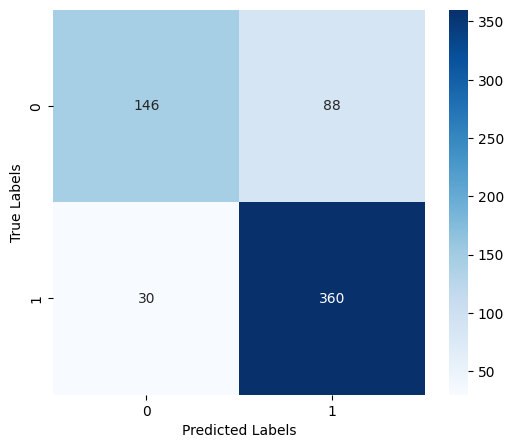

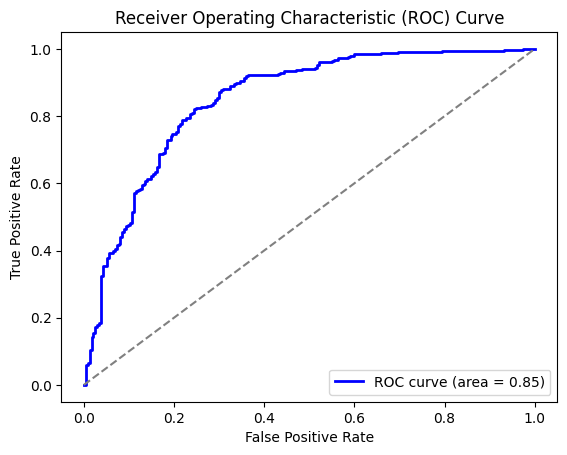

In [ ]:
evaluate_model(cnn_rnn_model, test_loader)


Class Distribution Visualization

<ipython-input-79-397897dd2485>:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_data = PneumoniaMNIST(split='train', transform=transform, target_transform=lambda x: int(x), download=True)


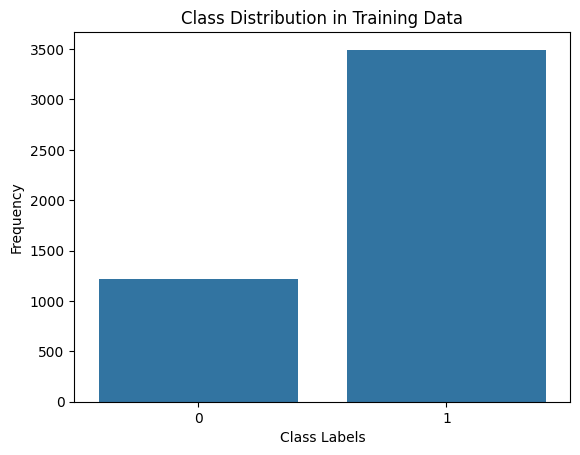

In [ ]:
labels = [label for _, label in train_data]
labels_df = pd.DataFrame(labels, columns=['Class'])
sns.countplot(x='Class', data=labels_df)
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Data')
plt.show()


# DeepLabV3

Install packages

In [ ]:
!pip install medmnist
!pip install segmentation-models-pytorch


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=67535ff1f23a45f0db288556992df09e647f6d4803c36f9ccbd99aa0e321623b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=0b949cdeae9f672df17836ef68fa4f525237a02cca62e4751ed20abc5b6c07b9
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from medmnist import PneumoniaMNIST
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from torchsummary import summary
import pandas as pd
import segmentation_models_pytorch as smp


Device Configuration

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


Data Transformations


In [ ]:
from torchvision.transforms import Resize

# Data Transformations (Updated)
transform = transforms.Compose([
    Resize((32, 32)),                      # Resize to 32x32 to match DeepLabv3 input requirements
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



Load PneumoniaMNIST Dataset

In [ ]:
# Updated Data Transformations to Resize Images to (32, 32)
transform = transforms.Compose([
    Resize((32, 32)),                      # Resize to 32x32
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])`````````````````

# Loading PneumoniaMNIST Dataset
train_data = PneumoniaMNIST(split='train', transform=transform, target_transform=lambda x: int(x), download=True)
val_data = PneumoniaMNIST(split='val', transform=transform, target_transform=lambda x: int(x), download=True)
test_data = PneumoniaMNIST(split='test', transform=transform, target_transform=lambda x: int(x), download=True)


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


Handle Class Imbalance

In [ ]:
#######*****

train_labels = [label for _, label in train_data]
class_counts = Counter(train_labels)
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(len(class_counts))]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


<ipython-input-39-6981f3665fd5>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_data = PneumoniaMNIST(split='train', transform=transform, target_transform=lambda x: int(x), download=True)


Data Loaders


In [ ]:
batch_size = 32
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)


Define DeepLabv3 Model

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn

class DeepLabv3ClassificationModel(nn.Module):
    def __init__(self):
        super(DeepLabv3ClassificationModel, self).__init__()
        # Use the DeepLabV3 with ResNet50 backbone
        self.deeplab = smp.DeepLabV3(
            encoder_name='resnet50',        # Use ResNet-50 as the encoder
            encoder_weights='imagenet',     # Pre-trained on ImageNet
            in_channels=1,                  # Single-channel input (grayscale)
            classes=2                       # Binary classification (not used directly)
        )

        # Global Average Pooling Layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layer for Classification
        self.fc = nn.Linear(2048, 2)  # Assuming ResNet-50 output feature map has 2048 channels

    def forward(self, x):
        # Forward pass through the encoder of DeepLabV3
        encoder_output = self.deeplab.encoder(x)

        # Ensure the encoder output is correctly extracted
        if isinstance(encoder_output, (tuple, list)):
            x = encoder_output[-1]  # Use the deepest feature map for classification
        else:
            x = encoder_output

        # Now x should be a tensor, suitable for the next layers
        x = self.global_avg_pool(x)  # Apply global average pooling
        x = torch.flatten(x, 1)      # Flatten the feature map to vector
        x = self.fc(x)               # Fully connected layer for classification
        return x

# Instantiate the model
deeplab_classification_model = DeepLabv3ClassificationModel().to(device)


Define Loss Function and Optimizer

In [ ]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(deeplab_classification_model.parameters(), lr=0.001)


Training Function

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).view(-1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).view(-1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_accuracy = 100 * val_correct / val_total
        val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        model.train()

# Train the Model
num_epochs = 10
train_model(deeplab_classification_model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)


<ipython-input-39-6981f3665fd5>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_data = PneumoniaMNIST(split='train', transform=transform, target_transform=lambda x: int(x), download=True)
<ipython-input-39-6981f3665fd5>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val_data = PneumoniaMNIST(split='val', transform=transform, target_transform=lambda x: int(x), download=True)


Epoch 1/10, Train Loss: 0.1939, Train Accuracy: 92.74%, Val Loss: 0.1377, Val Accuracy: 94.47%
Epoch 2/10, Train Loss: 0.1314, Train Accuracy: 95.11%, Val Loss: 0.1378, Val Accuracy: 96.18%
Epoch 3/10, Train Loss: 0.1282, Train Accuracy: 94.88%, Val Loss: 0.1000, Val Accuracy: 96.76%
Epoch 4/10, Train Loss: 0.1198, Train Accuracy: 95.48%, Val Loss: 0.1273, Val Accuracy: 96.18%
Epoch 5/10, Train Loss: 0.1085, Train Accuracy: 95.82%, Val Loss: 0.0906, Val Accuracy: 96.37%
Epoch 6/10, Train Loss: 0.1098, Train Accuracy: 96.30%, Val Loss: 0.0969, Val Accuracy: 95.80%
Epoch 7/10, Train Loss: 0.1257, Train Accuracy: 95.54%, Val Loss: 0.1871, Val Accuracy: 95.04%
Epoch 8/10, Train Loss: 0.1109, Train Accuracy: 96.22%, Val Loss: 0.1068, Val Accuracy: 93.89%
Epoch 9/10, Train Loss: 0.0963, Train Accuracy: 96.03%, Val Loss: 0.1373, Val Accuracy: 93.89%
Epoch 10/10, Train Loss: 0.0948, Train Accuracy: 96.16%, Val Loss: 0.0742, Val Accuracy: 97.14%


Evaluation Function

<ipython-input-39-6981f3665fd5>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_data = PneumoniaMNIST(split='test', transform=transform, target_transform=lambda x: int(x), download=True)


Accuracy: 0.8574
F1 Score: 0.8492
Recall: 0.8574
Precision: 0.8774
Confusion Matrix:
[[149  85]
 [  4 386]]


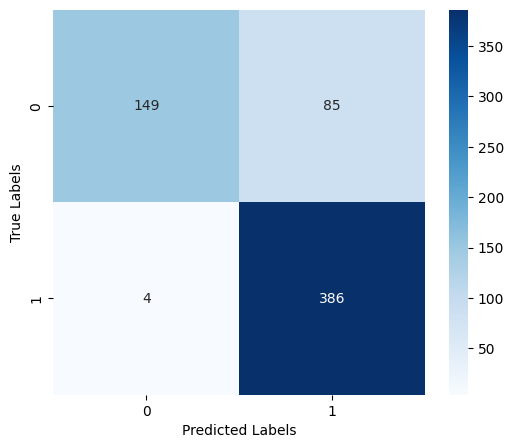

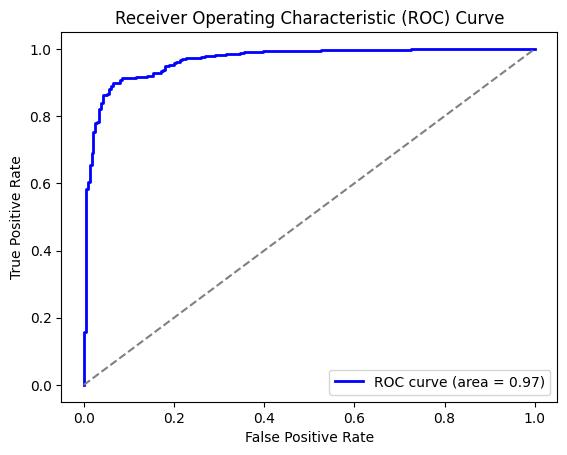

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_curve, auc

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_preds_prob = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).view(-1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            # Convert tensors to numpy arrays
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_preds_prob.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    # Ensure both are numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Compute metrics
    try:
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        precision = precision_score(all_labels, all_preds, average='weighted')
        conf_matrix = confusion_matrix(all_labels, all_preds)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}")

        # Plot confusion matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(all_labels, np.array(all_preds_prob)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()

    except ValueError as e:
        print(f"Error during metric calculation: {e}")

# Evaluate the Model
evaluate_model(deeplab_classification_model, test_loader)


Class Distribution Visualization

<ipython-input-39-6981f3665fd5>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  train_data = PneumoniaMNIST(split='train', transform=transform, target_transform=lambda x: int(x), download=True)


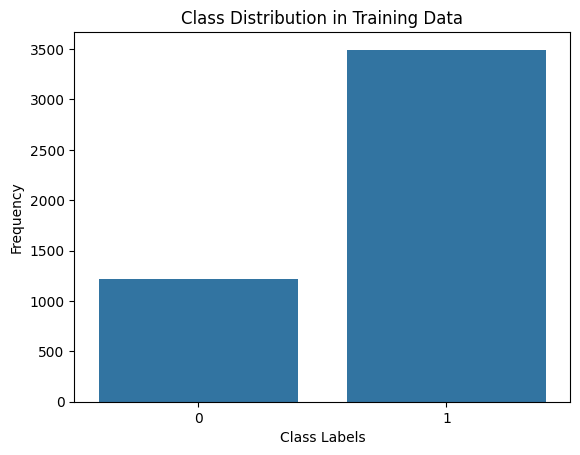

In [ ]:
labels = [label for _, label in train_data]
labels_df = pd.DataFrame(labels, columns=['Class'])
sns.countplot(x='Class', data=labels_df)
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Data')
plt.show()


Model Architecture Visualization

In [ ]:
from torchsummary import summary

# Update the input size to (1, 32, 32) as required by DeepLabv3
summary(deeplab_classification_model, input_size=(1, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           3,136
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [ ]:
#Show the final matrix of the final layer of deeplabv3

# Install torchviz (use this if you are working in Google Colab)
!pip install torchviz

import torch
from torchviz import make_dot

# Sample input to pass through the model
input_tensor = torch.randn(1, 1, 32, 32)  # Assuming grayscale X-rays resized to 32x32

# Forward pass through the model
deeplab_classification_model = DeepLabv3ClassificationModel()  # Use your trained model here
output = deeplab_classification_model(input_tensor)

# Generate the model diagram
model_viz = make_dot(output, params=dict(deeplab_classification_model.named_parameters()))
model_viz.format = 'png'
model_viz.render('deeplabv3_architecture')


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=d869ecbefb6c0edbab70e4d6410be94cdda586045775d317c2b1c7945864b76d
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


'deeplabv3_architecture.png'

In [ ]:
# Define the CNN-RNN model for visualization
cnn_rnn_model = CNNRNN()  # Use your trained model here
input_tensor_cnn_rnn = torch.randn(1, 1, 28, 28)  # Sample input of shape (batch_size, channels, height, width)

# Forward pass through the model
output_cnn_rnn = cnn_rnn_model(input_tensor_cnn_rnn)

# Generate the diagram using torchviz
model_viz_cnn_rnn = make_dot(output_cnn_rnn, params=dict(cnn_rnn_model.named_parameters()))
model_viz_cnn_rnn.format = 'png'
model_viz_cnn_rnn.render('cnn_rnn_architecture')


'cnn_rnn_architecture.png'

Save Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch

# Assuming 'deeplab_model' is your DeepLabv3 model and 'cnn_rnn_model' is the CNN-RNN hybrid model
deeplab_model_path = '/content/drive/My Drive/deeplab_model.pth'
cnn_rnn_model_path = '/content/drive/My Drive/cnn_rnn_model.pth'

# Save DeepLabv3 model
torch.save(deeplab_model.state_dict(), deeplab_model_path)
print(f"DeepLabv3 model saved at {deeplab_model_path}")

# Save CNN-RNN model
torch.save(cnn_rnn_model.state_dict(), cnn_rnn_model_path)
print(f"CNN-RNN model saved at {cnn_rnn_model_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DeepLabv3 model saved at /content/drive/My Drive/deeplab_model.pth
CNN-RNN model saved at /content/drive/My Drive/cnn_rnn_model.pth


Load Model

In [ ]:
# Load DeepLabv3 model
deeplab_model.load_state_dict(torch.load(deeplab_model_path))
deeplab_model.eval()  # Set to evaluation mode

# Load CNN-RNN model
cnn_rnn_model.load_state_dict(torch.load(cnn_rnn_model_path))
cnn_rnn_model.eval()  # Set to evaluation mode


NameError: name 'deeplab_model' is not defined